## Initialize

In [3]:
import numpy as np
import tensorflow as tf
import keras as k

Using TensorFlow backend.


## Hyper-parameters

In [29]:
# hyper parameters
BATCH_SIZE = 128
NUM_EPOCHS = 50
LEARNING_RATE, BETA_1 = 0.002, 0.8

## Preprocess

In [4]:
train = np.genfromtxt('data/train.csv', delimiter=',', skip_header=True)

In [33]:
# sperate inputs and labels
X_train = train[:, 1:]
Y_train = train[:, 0]

# add depth to image for CNN to process
X_train = np.reshape(X_train, (-1, 28, 28, 1))

# one hot encoding for labels
Y_train = k.utils.to_categorical(Y_train)

### Data Augmentation

In [34]:
# split data
from sklearn.model_selection import train_test_split
trainX, validationX, trainY, validationY  = train_test_split(X_train, Y_train, test_size=0.2, random_state=2)

# data augmentation
from keras.preprocessing.image import ImageDataGenerator
data_generator = ImageDataGenerator(
    rescale=1./255,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    rotation_range=20
)
data_generator.fit(trainX)
data_flow = data_generator.flow(trainX, trainY, batch_size=BATCH_SIZE)
valdiation_flow = data_generator.flow(validationX, validationY)

## Model

In [35]:
def convo2D(filters):
    return k.layers.Conv2D(
        filters=filters, 
        kernel_size=3, 
        strides=(1, 1), 
        padding='same', 
        activation=None,
        kernel_initializer=k.initializers.TruncatedNormal(stddev=0.1),
        bias_initializer=k.initializers.Constant(value=0.1)
    )

def create_model():
    k.backend.clear_session()
    model = k.models.Sequential()

    model.add(k.layers.InputLayer(input_shape=(28, 28, 1)))
    
    model.add(convo2D(32))
    model.add(k.layers.advanced_activations.ELU())
    model.add(k.layers.MaxPool2D(pool_size=2))
    
    model.add(k.layers.Dropout(0.2))
    model.add(convo2D(64))
    model.add(k.layers.advanced_activations.ELU())
    model.add(k.layers.MaxPool2D(pool_size=2))
    
    model.add(k.layers.Dropout(0.3))
    model.add(convo2D(128))
    model.add(k.layers.advanced_activations.ELU())
    model.add(k.layers.MaxPool2D(pool_size=2))
    model.add(k.layers.Dropout(0.4))
    
    model.add(convo2D(256))
    model.add(k.layers.advanced_activations.ELU())
    model.add(k.layers.GlobalAveragePooling2D())
    
    model.add(k.layers.Dropout(rate=0.3))
    model.add(k.layers.Dense(1024, kernel_regularizer=k.regularizers.l2(0.01)))
    model.add(k.layers.BatchNormalization())
    model.add(k.layers.Activation(activation='tanh'))

    model.add(k.layers.Dropout(rate=0.4))
    model.add(k.layers.Dense(256, kernel_regularizer=k.regularizers.l2(0.01)))
    model.add(k.layers.BatchNormalization())
    model.add(k.layers.Activation(activation='tanh'))
    
    model.add(k.layers.Dropout(rate=0.5))
    model.add(k.layers.Dense(10, activation='softmax'))
    
    return model

model = create_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
elu_1 (ELU)                  (None, 28, 28, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
elu_2 (ELU)                  (None, 14, 14, 64)        0         
__________

## Train

In [36]:
# optimize
optimizer = k.optimizers.Adam(lr=LEARNING_RATE, beta_1=BETA_1)
model.compile(optimizer, loss=k.losses.categorical_crossentropy, metrics=['accuracy'])

# early stopping
es = k.callbacks.EarlyStopping(monitor='loss', min_delta=0.0001, patience=10, verbose=1)

# plateu
rp = k.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=3, verbose=1, epsilon=0.001)

# checkpoint
cp = k.callbacks.ModelCheckpoint("checkpoint/model.hd5", monitor='val_acc', save_best_only=True)

# tensor board
tb = k.callbacks.TensorBoard(log_dir="logs/{}".format("with_augmentation"))

# train
num_steps = int(trainX.shape[0]/BATCH_SIZE)
model.fit_generator(
    data_flow, num_steps, epochs=NUM_EPOCHS, 
    validation_data=valdiation_flow, validation_steps=validationX.shape[0]/BATCH_SIZE, 
    verbose=2, callbacks=[tb, es, rp, cp])

Epoch 1/50
99s - loss: 3.3997 - acc: 0.5242 - val_loss: 1.4568 - val_acc: 0.5734
Epoch 2/50


KeyboardInterrupt: 

## Test

In [37]:
# load data
test = np.genfromtxt('data/test.csv', delimiter=',', skip_header=True)
test = test.reshape((test.shape[0], 28, 28, 1))/255

In [38]:
# predict
final_model = k.models.load_model("checkpoint/model.hd5")
pred = final_model.predict_classes(test[:10])

10/10 [==============================] - 0s


In [39]:
# save prediction
pred = np.reshape(pred, (pred.shape[0], 1))
index = np.arange(1, pred.shape[0]+1).reshape((pred.shape[0], 1))
pred = np.concatenate((index, pred), axis=1)
np.savetxt("submission.csv", pred, delimiter=",", header='ImageId,Label', fmt='%d', comments='')

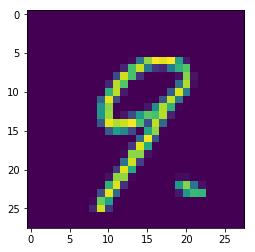

In [127]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

plt.imshow(test[2].reshape(28, 28))

In [40]:
%cat submission.csv

ImageId,Label
1,2
2,9
3,9
4,9
5,3
6,9
7,4
8,3
9,4
10,3
